In [1]:
import os
import re
import sys
import json
import copy
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.backends.backend_pdf import PdfPages

import torch

import seaborn as sns

import IPython.display

import ipywidgets as widgets

In [2]:
import matplotlib
font = {'family' : 'sans-serif',
        'size'   : 14}

matplotlib.rc('font', **font)

In [3]:
RES_DIR = "/data/t-achetan/dumps/expC_dist_learner_for_adv_ex/rdm_concspheres_test/attack_perfs_on_runs/all_attack_perfs/"

all_run_files = [i for i in os.listdir(RES_DIR) if i.endswith(".json")]
all_run_files

req_files_k50n500 = [
    "rdm_concspheres_k50n500_noninfdist_moreoffmfldv3_bs4096-2-clf.json",
    "rdm_concspheres_k50n500_noninfdist_moreoffmfld_advtraindebug_bs4096_eps=5e-2-2-clf.json",
    "rdm_concspheres_k50n500_noninfdist_moreoffmfld_advtraindebug_bs4096_eps=8e-2-1-clf.json",
#     "rdm_concspheres_k50n500_noninfdist_moreoffmfld_advtraindebug_eps=1e-1-1-clf.json",
    "rdm_concspheres_k50n500_noninfdist_moreoffmfldv3_bs4096_highmn40_inferred_maxtdelta_1e-3-1-regression_last.json",
#     "rdm_concspheres_k50n500_noninfdist_moreoffmfldv3_bs4096_highmn40_inferred_maxtdelta_2.5e-3-1-regression_last.json",
#     "rdm_concspheres_k50n500_noninfdist_moreoffmfldv3_bs4096_highmn40_inferred_maxtdelta_5e-3-2-regression_last.json",

]

req_labels_k50n500 = [
    "SC",
    r"RC ($\eta=5\mathrm{e}-2$)",
    r"RC ($\eta=8\mathrm{e}-2$)",
#     r"RC ($\epsilon=1\mathrm{e}-1$)",
#     r"DL ($max\_tang=1\mathrm{e}-3$)",
#     r"DL ($max\_tang=2.5\mathrm{e}-3$)",
    r"DL",
]

markers = ["o", "X", "s", "D"]

In [4]:
master_df = None
for f in req_files_k50n500:
    res_file = os.path.join(RES_DIR, f)
    if master_df is None:
        master_df = pd.read_json(res_file)
    else:
        tmp = pd.read_json(res_file)
        master_df = pd.concat([master_df, tmp], ignore_index=True)
columns = master_df.columns.tolist()
drop_dup_by_columns = [i for i in columns if "clf_report" not in i]
master_df.drop_duplicates(drop_dup_by_columns, inplace=True)

In [5]:
#### setting hyperparameters which will be fixed!!!

ths = [0.14]
eps_iter = 5e-03
count_offmfld_pred_corr = False # count off manifold predictions as accurate
discard_offmfld_pred = False
off_mfld_label = "2"
# N = 100000


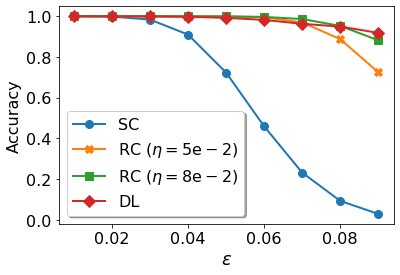

In [27]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4), sharey=True)

for k in range(len(ths)):
    thresh = ths[k]
    for j in range(len(req_files_k50n500)):
        file = req_files_k50n500[j]
        full_fn = os.path.join(RES_DIR, file)
        df = pd.read_json(full_fn)

        eps_arr = df.eps.unique()[:-1]

        task = df.task.unique()[0]
        run_tag = None
        run_id = None
        try:
            run_tag = df.run_tag.unique()[0]
            run_id = df.run_id.unique()[0]
        except:
            run_tag = "rdm_concspheres_k50n500_noninfdist"
            run_id = 1
        perf = np.zeros(eps_arr.shape)
#         print(file)
        for i in range(eps_arr.shape[0]):
            eps = eps_arr[i]
            if task == "dist":
                path_to_load = df[(np.round(df.thresh, 2) == thresh) & (df.eps == eps) & (np.round(df.eps_iter, 3) == eps_iter)].adv_pct_cm.tolist()[0]
                if not os.path.exists(path_to_load):
                    print("not found")
                    tmp = path_to_load.find("t-achetan")
                    offset = 10
                    if "t-achetan_2" in path_to_load:
                        offset = 12
                    path_to_load = path_to_load[:tmp] + path_to_load[tmp+offset:]
#                 print(path_to_load)
                adv_pct_cm_df = pd.read_csv(path_to_load, index_col=0)
                adv_pct_cm = adv_pct_cm_df.to_numpy()
                perf[i] = np.trace(adv_pct_cm)
                if count_offmfld_pred_corr:
                    if off_mfld_label in adv_pct_cm_df.columns: 
                        off_mfld_stats = adv_pct_cm_df["2"].to_numpy()
                        if off_mfld_stats.shape[0] == adv_pct_cm.shape[0]:
                            perf[i] += np.sum(off_mfld_stats[:-1])
                        else:
                            perf[i] += np.sum(off_mfld_stats[:])
                elif discard_offmfld_pred:
                    end_row = adv_pct_cm.shape[0]
                    end_col = adv_pct_cm.shape[1]
                    if off_mfld_label in adv_pct_cm_df.columns:
                        end_col = -1
                    if end_row == int(off_mfld_label) + 1:
                        end_row = -1
                    perf[i] = np.trace(adv_pct_cm[:end_row, :end_col]) / np.sum(adv_pct_cm[:end_row, :end_col])

            elif task == "clf":
                path_to_load = df[(df.eps == eps) & (np.round(df.eps_iter, 3) == eps_iter)].adv_pct_cm.tolist()[0]
#                 print(path_to_load)
                if not os.path.exists(path_to_load):
                    tmp = path_to_load.find("t-achetan")
                    if tmp == -1:
                        path_to_load = path_to_load.replace("/data/", "/data/t-achetan/")
                    else: path_to_load = path_to_load[:tmp] + path_to_load[tmp+8:]

                adv_pct_cm = pd.read_csv(path_to_load, index_col=0).to_numpy()
                perf[i] = np.trace(adv_pct_cm)
    #         print(perf)
    #     label = "baseline-clf"
    #     if "advtrain" in run_tag:
    # #         if "4096" in run_tag:
    # #             label = "advtrain-clf eps=1e-1 bs=4096"
    # #         elif ""
    # #         else:
    # #             label="advtrain-clf eps=3e-2"
    #         label = run_tag.lstrip("rdm_concspheres_k50n500_noninfdist_moreoffmfldv")
    #         label = label.lstrip("3_")
    #         label = label + " clf"
    #         label = re.sub("debug", "", label)
    #     elif task == "dist":
    #         if "2048" in file:
    #             label = "v3-bs2048 th={}".format(thresh)
    #         elif "moreoffmfld" not in file:
    #             label = "v0 noninf"
    #         elif "v5" in file:
    #             label = "v5-bs4096 th={}".format(thresh)
    #         elif "v4" in file:
    #             label = "v4-bs4096 th={}".format(thresh)
    #         elif "v3" in file:
    #             label = "v3-bs4096 th={}".format(thresh)
    #             if "inferred" in file:
    #                 label += " inf"
    #             if "maxtdelta" in file:
    #                 max_t_delta = "-".join(file.split("_")[-2].split("-")[:2])
    #                 label +=  " mtd={}".format(max_t_delta)
    #         elif "inferred" in file:
    #             label = "v0-bs4096 inf"
    #         else:
    #             label = "v3-bs4096 th={}".format(thresh)

    #         if "highmn" in file:
    #             print(df.max_norm.unique())
    #             label += " mn={}".format(df.max_norm.unique()[0])

    #     label += " run_id={}".format(run_id)

        label = req_labels_k50n500[j]
        axs.plot(eps_arr, perf, label=label, marker=markers[j], markersize=8, linewidth=2)
#         axs[k].plot(eps_arr, perf, label=label, marker="o")
#         axs[k].set_title("thresh={}, eps_iter={}".format(thresh, eps_iter))
#         if k == 0:
#             axs[k].set_title("First Variant")
#         elif k == 1:
#             axs[k].set_title("Second Variant (th={})".format(thresh))
        
# axs[-1].legend(bbox_to_anchor =(0.7, -0.2), fancybox=True, shadow=True, ncol=4)
axs.legend(fancybox=True, shadow=True)
# plt.rcParams.update({'font.size': 16})

axs.set_xlabel(r"$\epsilon$", fontsize=18)
# axs[1].set_xlabel(r"$\epsilon$")
axs.set_ylabel("Accuracy", fontsize=16)
plt.savefig("adv_robustness_plot_poster.pdf", bbox_inches="tight")
# plt.suptitle("advtrain clf vs stdclf")
# plt.savefig("paper_plot_advtrain_v_stdclf_th={}_countoffmfldcorr={}_discardoffmfldpred={}.pdf".format(thresh, count_offmfld_pred_corr, discard_offmfld_pred), type="pdf", bbox_inches="tight")
plt.show()


In [10]:
! ls /data/t-achetan/dumps/expC_dist_learner_for_adv_ex/rdm_concspheres_test/rdm_concspheres_k50n500_noninfdist_moreoffmfldv3_bs4096/2

attack_perf  logits	   rsync_bkup_sanity_check_cout.txt  tensorboard
config.json  metrics.json  run.json
cout.txt     models	   specs.json


In [12]:
"s".find("a")

-1

In [14]:
"a".replace("a", "b")

'b'